# Cifar-10 이미지 분류(with Data Augmentation)

In [1]:
import numpy as np 
import tensorflow as tf
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

- 상수 설정

In [2]:
BATCH_SIZE = 32
NUM_CLASSES = 10
EPOCHS = 100
DATA_AUGMENTATION = True
NUM_PREDICTIONS = 20
MODEL_PATH = 'model/best_cifar-10.h5'

### 데이터 전처리

In [3]:
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 5s 0us/step


In [4]:
X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

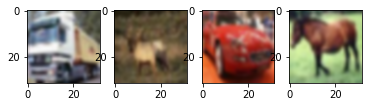

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(141)
plt.imshow(X_train[1], interpolation='bicubic')
plt.subplot(142)
plt.imshow(X_train[3], interpolation='bicubic')
plt.subplot(143)
plt.imshow(X_train[5], interpolation='bicubic')
plt.subplot(144)
plt.imshow(X_train[7], interpolation='bicubic')
plt.show()

In [7]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
class_names[y_train[1][0]], class_names[y_train[3][0]], \
    class_names[y_train[5][0]], class_names[y_train[7][0]]

('truck', 'deer', 'automobile', 'horse')

In [8]:
# 0~1 사이로 정규화
X_train = X_train / 255.0
X_test = X_test / 255.0

In [9]:
# One-hot encoding
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
Y_train.shape, Y_test.shape

((50000, 10), (10000, 10))

### 모델 정의/설정

In [10]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [11]:
model = Sequential([ 
    Conv2D(32, (3,3), padding='same', input_shape=(32,32,3), activation='relu'),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),

    Conv2D(64, (3,3), padding='same', activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25), 

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')        
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0

In [12]:
from tensorflow.keras.optimizers import RMSprop
opt = RMSprop(learning_rate=0.0001, decay=1e-6)

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
import os
if not os.path.exists('model'):
    os.mkdir('model')
checkpointer = ModelCheckpoint(
    MODEL_PATH, verbose=1, save_best_only=True
)
early_stopping = EarlyStopping(patience=10)

### 데이터 부풀리기

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_train, Y_train, stratify=Y_train, test_size=0.2, random_state=seed
)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,   # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,   # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    zca_epsilon=1e-06,    # epsilon for ZCA whitening
    rotation_range=0,     # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    shear_range=0.,  # set range for random shear
    zoom_range=0.,   # set range for random zoom
    channel_shift_range=0.,  # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    cval=0.,  # value used for fill_mode = "constant"
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,   # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0
)
datagen.fit(X_train)

In [ ]:
history = model.fit(
    X_train, Y_train, validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    callbacks=[checkpointer, early_stopping]
)

Epoch 1/100
1250/1250 [==============================] - 39s 6ms/step - loss: 1.8938 - accuracy: 0.3070 - val_loss: 1.6281 - val_accuracy: 0.4183

Epoch 00001: val_loss improved from inf to 1.62811, saving model to best_cifar-10.h5
Epoch 2/100
1250/1250 [==============================] - 7s 5ms/step - loss: 1.5690 - accuracy: 0.4269 - val_loss: 1.4859 - val_accuracy: 0.4630

Epoch 00002: val_loss improved from 1.62811 to 1.48590, saving model to best_cifar-10.h5
Epoch 3/100
1250/1250 [==============================] - 7s 5ms/step - loss: 1.4365 - accuracy: 0.4809 - val_loss: 1.3610 - val_accuracy: 0.5217

Epoch 00003: val_loss improved from 1.48590 to 1.36105, saving model to best_cifar-10.h5
Epoch 4/100
1250/1250 [==============================] - 7s 5ms/step - loss: 1.3430 - accuracy: 0.5185 - val_loss: 1.2389 - val_accuracy: 0.5660

Epoch 00004: val_loss improved from 1.36105 to 1.23890, saving model to best_cifar-10.h5
Epoch 5/100
1250/1250 [==============================] - 7s 5ms

In [ ]:
best_model = load_model(MODEL_PATH)
best_model.evaluate(X_test, Y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.6484 - accuracy: 0.7901


[0.6483571529388428, 0.7900999784469604]